In [1]:
import numpy as np 
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [4]:
#cd '/Users/nikhilsingh/Downloads/Dalmia_machine_learning/Nikhil' 

/Users/nikhilsingh/Downloads/Dalmia_machine_learning/Nikhil


In [5]:
from utility.db_data import connection_db
from utility.datetime_util import create_date_columns

#### Dealer's muscle

In [6]:
host="database-dalmia.cms6cet2hwec.ap-south-1.rds.amazonaws.com"
database="dalmia_digital"
user="postgres"
password="dalmia123"
sql_query =  "SELECT * FROM dalmia_sales.sales_data where billing_date >='2021-04-01' and sold_to_party_code between 7000000 and 7099999"
#reading the data
df = connection_db(host= host , database=database, user=user , password=password, sql_query=sql_query)
# df = pd.read_excel('data/sales_data_pivot - UPDATED WORKING.xlsx')

In [7]:
df.head()

,month,billing_date,sales_region,sales_zone,sales_type,manufacturing_plant,manufacturing_plant_name,plant,plant_name,sold_to_party_code,...,direct_depot,incoterms_inco,mode_of_transport,t_zone,tzone_desc,brand,product,bill_quantity,gross_bill_price,zbill_invoice_bill
0,Jul'23,2023-07-26,North East,NE1,Trade,3300,DCNEL FACTORY – LANKA,3300,DCNEL FACTORY – LANKA,7007301,...,Direct,FPD,Road,7833840320,ABHAYAPURI,DSP,DSP,25.0,253000,253000.0
1,Jul'23,2023-07-31,North East,NE1,Trade,3300,DCNEL FACTORY – LANKA,3300,DCNEL FACTORY – LANKA,7007301,...,Direct,FPD,Road,7833840320,ABHAYAPURI,DSP,DSP,15.0,151800,151800.0
2,Jul'23,2023-07-31,North East,NE1,Trade,3300,DCNEL FACTORY – LANKA,3300,DCNEL FACTORY – LANKA,7007301,...,Direct,FPD,Road,7833840320,ABHAYAPURI,DALMIA,PPC,10.0,95200,95200.0
3,Jul'23,2023-07-10,North East,NE1,Trade,6300,ALSTHOM FACTORY-JAGI ROAD,6300,ALSTHOM FACTORY-JAGI ROAD,7007301,...,Direct,FPD,Road,7833840320,ABHAYAPURI,DALMIA,PPC,4.0,38080,38080.0
4,Jul'23,2023-07-12,North East,NE1,Trade,6300,ALSTHOM FACTORY-JAGI ROAD,6300,ALSTHOM FACTORY-JAGI ROAD,7007301,...,Direct,FPD,Road,7833840320,ABHAYAPURI,DSP,DSP,15.0,151800,151800.0


In [8]:
def return_yoy_df(df):
    df_sales = create_date_columns([df])
    df_sales = df_sales[['sold_to_party_code','Month_Year','bill_quantity']]
    #df_sales =df_sales[df_sales['sold_to_party_code']!='DONATION']
    df_group_month = df_sales.groupby(['sold_to_party_code','Month_Year']).agg({'bill_quantity': ['sum']}).reset_index()
    df_group_month.columns = ['Sold To Party Code', 'Month Year' , 'Sum']
    pivot_table = pd.pivot_table(df_group_month, values='Sum',columns='Month Year', index = 'Sold To Party Code')
    return pivot_table
pivot = return_yoy_df(df)

In [9]:
pivot = pivot.fillna(0)

In [11]:
df['day_of_month'] = pd.to_datetime(df['billing_date']).dt.day
df['week_of_month'] = (df['day_of_month']-1)//7+1

In [21]:
df_sales = df[['sold_to_party_code','Month_Year',  'week_of_month','bill_quantity']].copy()

In [22]:
df_sales.head()

,sold_to_party_code,Month_Year,week_of_month,bill_quantity
0,7007301,2023-07,4,25.0
1,7007301,2023-07,5,15.0
2,7007301,2023-07,5,10.0
3,7007301,2023-07,2,4.0
4,7007301,2023-07,2,15.0


In [29]:
df_group_week = df_sales.groupby(['sold_to_party_code','Month_Year','week_of_month']).agg({'bill_quantity': ['sum']}).reset_index()

In [33]:
df_group_week.columns = ['Sold To Party Code', 'Month Year' , 'Week of Month','Sum']

In [35]:
pivot_table = pd.pivot_table(df_group_week, values='Sum',columns=['Month Year','Week of Month'], index = 'Sold To Party Code')

In [38]:
pivot_table = pivot_table.fillna(0)

In [39]:
pivot_table.to_excel('data/weekly_pivot.xlsx')

In [40]:
influencer = pd.read_excel('data/Influencer Mapping.xlsx')

In [41]:
influencer_group = influencer[['Tagged Dealer SAP Code',
                               'Membership Id']].groupby(by= 'Tagged Dealer SAP Code').agg({'Membership Id':['count']}).reset_index()

In [42]:
host="database-dalmia.cms6cet2hwec.ap-south-1.rds.amazonaws.com"
database="dalmia_digital"
user="postgres"
password="dalmia123"
sql_query =  "select * from dalmia_sales.dealer_target"
#reading the data
target = connection_db(host= host , database=database, user=user , password=password, sql_query=sql_query)

In [43]:
target = target[target['dealer_id']!='Grand Total']
target['dealer_id'] = target['dealer_id'].astype('int')

In [44]:
target = target[['dealer_id','total_2022_04','total_2022_05','total_2022_06','total_2022_07','total_2022_08',
                'total_2022_09','total_2022_10','total_2022_11','total_2022_12','total_2023_01','total_2023_02','total_2023_03',
                'total_2023_04','total_2023_05']]

In [45]:
target = target[(target['dealer_id']>=7000000)&(target['dealer_id']<7100000)]

In [46]:
target.index = target['dealer_id']
target.drop('dealer_id' , axis = 1 , inplace = True)

In [47]:
influencer_group.columns = ['dealer_id' , 'influencer_count']

In [48]:
influencer_group.index = influencer_group['dealer_id']
influencer_group.drop('dealer_id', axis = 1 , inplace =True)

In [49]:
data = target.merge(influencer_group , left_index=True , right_index=True , how = 'left')

In [50]:
data_1 = data.merge(pivot , left_index=True , right_index=True , how = 'inner')

In [51]:
test = data_1

In [52]:
test = test.fillna(0)

In [53]:
total = ['total_2022_04', 'total_2022_05', 'total_2022_06', 'total_2022_07',
       'total_2022_08', 'total_2022_09', 'total_2022_10', 'total_2022_11',
       'total_2022_12', 'total_2023_01', 'total_2023_02', 'total_2023_03',
       'total_2023_04', 'total_2023_05']
test['total_target'] = 0
for i in total:
    test['total_target'] = test[i]+test['total_target']

In [78]:
sales = ['2022-04', '2022-05', '2022-06', '2022-07',
       '2022-08', '2022-09', '2022-10', '2022-11', '2022-12', '2023-01',
       '2023-02', '2023-03']
test['total_sales'] = 0
for i in sales:
    test['total_sales'] = test[i]+test['total_sales']

In [79]:
sales = ['2021-04', '2021-05', '2021-06', '2021-07',
       '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01',
       '2022-02', '2022-03']
test['previous_sales'] = test[sales].sum(axis = 1)


In [80]:
test['target_achieved'] =test['total_sales']/test['total_target']

In [81]:
cluster_df = test[['total_sales'  , 'influencer_count' , 'target_achieved', 'previous_sales']].copy()

In [89]:
cluster_df = cluster_df[cluster_df['total_sales']!=0]
cluster_df = cluster_df+1

In [90]:
from sklearn.preprocessing import MinMaxScaler
def factor_analysis(df):
    Sc = MinMaxScaler()
    scaled_df = Sc.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_df , columns = df.columns)
    covariance_matrix = np.cov(scaled_df.T)
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
    return explained_variance_ratio , scaled_df

def deciles(number): 
    if number==0:
        return 0
    if number>0 and number<0.1:
        return 1
    if number>=0.1 and number<0.2:
        return 2
    if number>=0.2 and number<0.3:
        return 3
    if number>=0.3 and number<0.4:
        return 4
    if number>=0.4 and number<0.5:
        return 5
    if number>=0.5 and number<0.6:
        return 6
    if number>=0.6 and number<0.7:
        return 7
    if number>=0.7 and number<0.8:
        return 8
    if number>=0.8 and number<0.9:
        return 9
    if number>=0.9 and number<=1:
        return 10

In [93]:
cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11746 entries, 7000004 to 7039802
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   total_sales       11746 non-null  float64
 1   influencer_count  11746 non-null  float64
 2   target_achieved   11746 non-null  float64
 3   previous_sales    11746 non-null  float64
dtypes: float64(4)
memory usage: 458.8 KB


In [91]:
cluster_df = cluster_df.astype('float64')

In [92]:
aaaa = MinMaxScaler().fit_transform(cluster_df)

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [77]:
playbook = pd.read_csv('data/playbook_rating.csv')
playbook.index = playbook['Unnamed: 0']
playbook.drop('Unnamed: 0', axis = 1 , inplace = True)
playbook.drop('rating', axis = 1, inplace = True)
playbook['bargain_r'] = playbook['bargain_r'].clip(upper=9.89)

In [78]:
playbook

,muscle_r,bargain_r,relationship_r
Unnamed: 0,,,
7000004,7.443198,4.894111,3.716716
7000010,4.514641,3.105889,5.610527
7000015,5.969782,2.105889,3.195017
7000022,4.412979,1.035296,4.859292
7000025,8.443198,3.929407,5.966425
...,...,...,...
7037393,4.089719,6.035296,4.066106
7037396,3.048494,4.858815,3.506210
7037404,6.066770,9.682333,3.461285


In [81]:
expl , _ = factor_analysis(playbook)

array([0.5992867 , 0.26702217, 0.13369113])

In [83]:
playbook['rating'] = playbook['muscle_r']*expl[0]+playbook['bargain_r']*expl[1]+playbook['relationship_r']*expl[2]

In [80]:
playbook['bargain_r'].max()

9.89

In [86]:
playbook.to_csv('data/playbook_rating_2.csv')

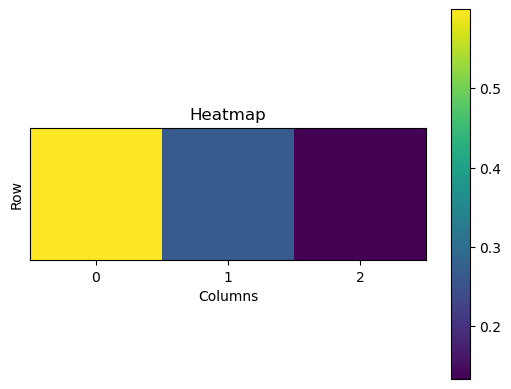

In [91]:
import matplotlib.pyplot as plt

# Given array
data = np.array([0.5992867, 0.26702217, 0.13369113])

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the heatmap as a row
heatmap = ax.imshow(data.reshape(1, -1))

# Customize the plot
ax.set_title('Heatmap')
ax.set_xlabel('Columns')
ax.set_ylabel('Row')
ax.set_xticks(np.arange(len(data)))
ax.set_xticklabels(np.arange(len(data)))
ax.set_yticks([])
ax.grid(False)

# Add colorbar
cbar = fig.colorbar(heatmap)

# Show the plot
plt.show()





ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (3).

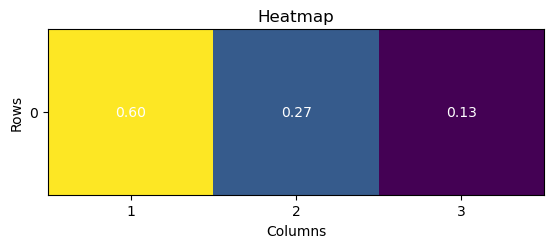

In [96]:
import numpy as np
import matplotlib.pyplot as plt

# Given array and row names
data = np.array([0.5992867, 0.26702217, 0.13369113])
row_names = ['name_1', 'name_2', 'name_3']

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the heatmap as a row with numbers displayed
heatmap = ax.imshow(data.reshape(1,-1))

# Customize the plot
ax.set_title('Heatmap')
ax.set_xlabel('Columns')
ax.set_ylabel('Rows')
ax.set_xticks(np.arange(len(data)))
ax.set_xticklabels(np.arange(1, len(data) + 1))  # Column numbering starts from 1
ax.set_yticks([])
ax.grid(False)

# Add numbers inside the heatmap cells
for i in range(len(data)):
    ax.text(i, 0, f'{data[i]:.2f}', va='center', ha='center', color='white')

# Add row names
ax.set_yticks([0])
ax.set_yticklabels(row_names)

# Add colorbar
cbar = fig.colorbar(heatmap)

# Show the plot
plt.show()


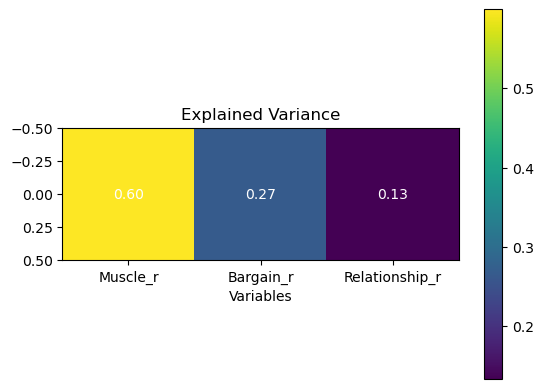

In [101]:
import numpy as np
import matplotlib.pyplot as plt

# Given array and row names
data = np.array([0.5992867, 0.26702217, 0.13369113])
row_names = ['Muscle_r', 'Bargain_r', 'Relationship_r']

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the heatmap as a row with numbers displayed
heatmap = ax.imshow(data.reshape(1, -1))

# Customize the plot
ax.set_title('Explained Variance')
ax.set_xlabel('Variables')
#ax.set_ylabel('Rows')
ax.set_xticks(np.arange(len(data)))
ax.set_xticklabels(np.arange(1, len(data) + 1))  # Column numbering starts from 1

# Set the number of locator locations to match the number of row names
ax.set_xticks(np.arange(len(row_names)))
ax.set_xticklabels(row_names)

ax.grid(False)

# Add numbers inside the heatmap cells
for i in range(len(data)):
    ax.text(i, 0, f'{data[i]:.2f}', va='center', ha='center', color='white')

# Add colorbar
cbar = fig.colorbar(heatmap)

# Show the plot
plt.show()
